<a href="https://colab.research.google.com/github/arifpras/PredictingStock/blob/main/20240305_lstm03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%%capture

#!pip install ccxt

In [7]:
import pandas as pd

df = pd.read_excel('/content/drive/MyDrive/01lstm/bbri.xlsx', sheet_name='Sheet1')
df['price'] = df['price'].astype(float)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1229 entries, 0 to 1228
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1229 non-null   datetime64[ns]
 1   price   1229 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.3 KB


Text(0.5, 1.0, 'BBNI Daily Close Price')

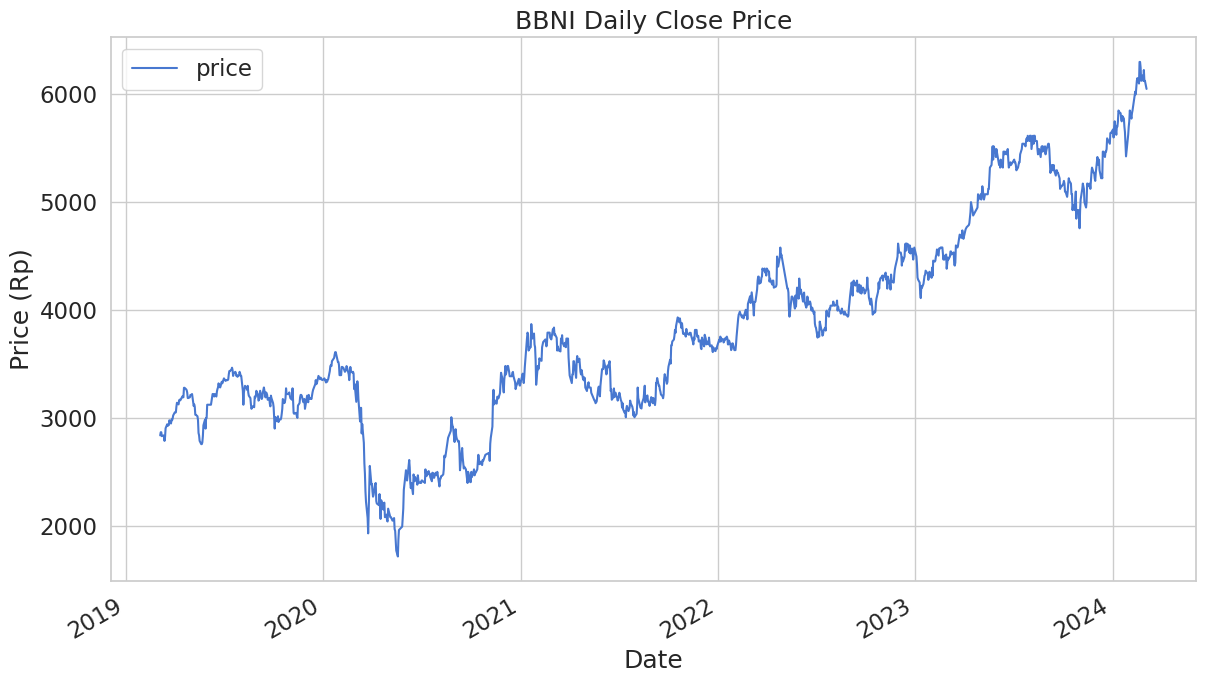

In [9]:
%matplotlib inline
from pylab import rcParams
import matplotlib.pyplot as plt
import seaborn as sns

rcParams['figure.figsize'] = 14, 8
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

# data plot
ax = df.plot(x='date', y='price');
ax.set_xlabel('Date')
ax.set_ylabel('Price (Rp)')
ax.set_title('BBNI Daily Close Price')


In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# fit the format of the scaler -> convert shape from (1000, ) -> (1000, 1)
close_price = df.price.values.reshape(-1, 1)
scaled_close = scaler.fit_transform(close_price)

In [15]:
import numpy as np

seq_len = 60

def split_into_sequences(data, seq_len):
    n_seq = len(data) - seq_len + 1
    return np.array([data[i:(i+seq_len)] for i in range(n_seq)])

def get_train_test_sets(data, seq_len, train_frac):
    sequences = split_into_sequences(data, seq_len)
    n_train = int(sequences.shape[0] * train_frac)
    X_train = sequences[:n_train, :-1, :]
    y_train = sequences[:n_train, -1, :]
    X_test = sequences[n_train:, :-1, :]
    y_test = sequences[n_train:, -1, :]
    return X_train, y_train, X_test, y_test

x_train, y_train, x_test, y_test = get_train_test_sets(scaled_close, seq_len, train_frac=0.9)


In [16]:
from tensorflow import keras
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential

# fraction of the input to drop; helps prevent overfitting
dropout = 0.2
window_size = seq_len - 1

# build a 3-layer LSTM RNN
model = keras.Sequential()

model.add(
    LSTM(window_size, return_sequences=True,
         input_shape=(window_size, x_train.shape[-1]))
)

model.add(Dropout(rate=dropout))
# Bidirectional allows for training of sequence data forwards and backwards
model.add(
    Bidirectional(LSTM((window_size * 2), return_sequences=True)
))

model.add(Dropout(rate=dropout))
model.add(
    Bidirectional(LSTM(window_size, return_sequences=False))
)

model.add(Dense(units=1))
# linear activation function: activation is proportional to the input
model.add(Activation('linear'))


In [ ]:
# batch_size = 16

# model.compile(
#     loss='mean_squared_error',
#     optimizer='adam'
# )

# history = model.fit(
#     x_train,
#     y_train,
#     epochs=10,
#     batch_size=batch_size,
#     shuffle=False,
#     validation_split=0.2
# )


In [22]:
batch_size = 32

model.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

history = model.fit(
    x_train,
    y_train,
    epochs=50,
    batch_size=batch_size,
    shuffle=True,
    verbose=1
)

Epoch 1/50
33/33 [==============================] - 29s 552ms/step - loss: 0.0017
Epoch 2/50
33/33 [==============================] - 15s 474ms/step - loss: 9.8097e-04
Epoch 3/50
33/33 [==============================] - 16s 486ms/step - loss: 9.5598e-04
Epoch 4/50
33/33 [==============================] - 16s 483ms/step - loss: 8.2779e-04
Epoch 5/50
33/33 [==============================] - 17s 525ms/step - loss: 7.0230e-04
Epoch 6/50
33/33 [==============================] - 18s 538ms/step - loss: 7.5867e-04
Epoch 7/50
33/33 [==============================] - 15s 461ms/step - loss: 6.7913e-04
Epoch 8/50
33/33 [==============================] - 15s 466ms/step - loss: 6.5320e-04
Epoch 9/50
33/33 [==============================] - 17s 532ms/step - loss: 6.8397e-04
Epoch 10/50
33/33 [==============================] - 16s 498ms/step - loss: 5.8253e-04
Epoch 11/50
33/33 [==============================] - 18s 555ms/step - loss: 6.0379e-04
Epoch 12/50
33/33 [==============================] - 18s

In [ ]:
# batch_size = 32  # Adjusted batch size for better performance

# model.compile(
#     loss='mean_squared_error',
#     optimizer='adam'  # Keeping the optimizer as 'adam'
# )

# history = model.fit(
#     x_train,
#     y_train,
#     epochs=20,  # Increased the number of epochs for better convergence
#     batch_size=batch_size,
#     shuffle=True,  # Set shuffle to True for better training
#     validation_split=0.2
# )

4/4 [==============================] - 3s 76ms/step


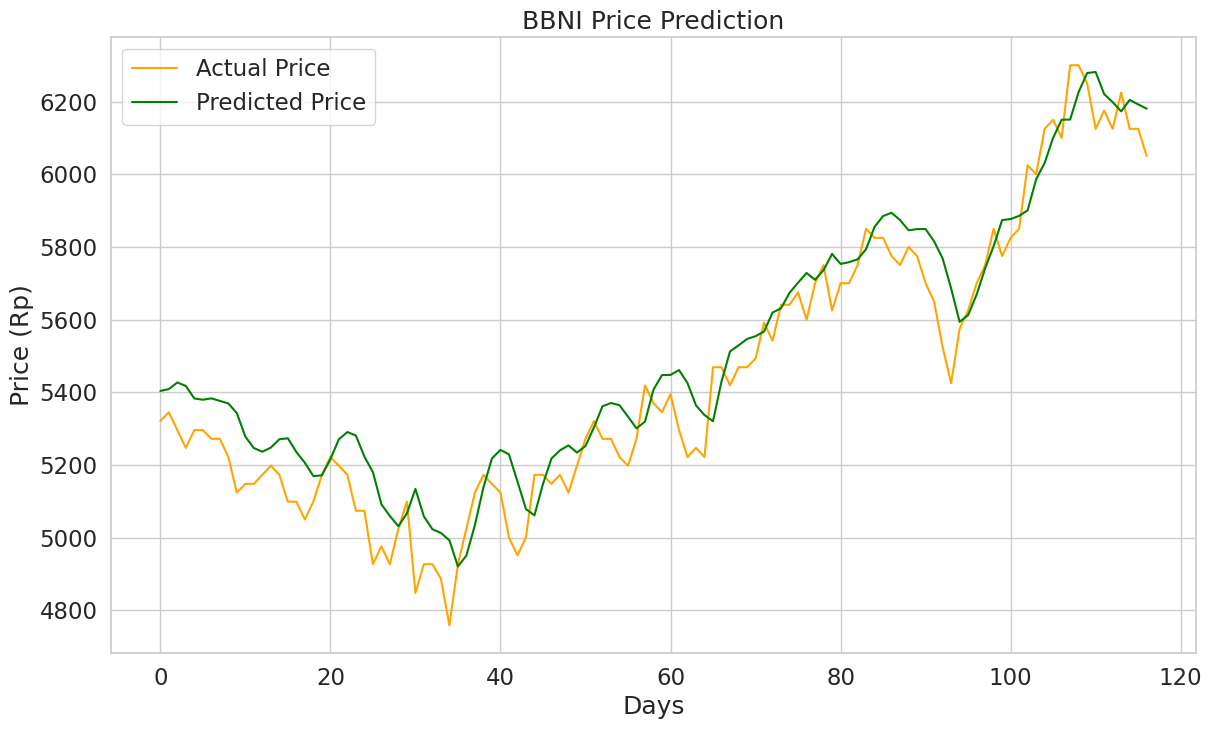

In [23]:
y_pred = model.predict(x_test)

# invert the scaler to get the absolute price data
y_test_orig = scaler.inverse_transform(y_test)
y_pred_orig = scaler.inverse_transform(y_pred)

# plots of prediction against actual data
plt.plot(y_test_orig, label='Actual Price', color='orange')
plt.plot(y_pred_orig, label='Predicted Price', color='green')

plt.title('BBNI Price Prediction')
plt.xlabel('Days')
plt.ylabel('Price (Rp)')
plt.legend(loc='best')

plt.show();


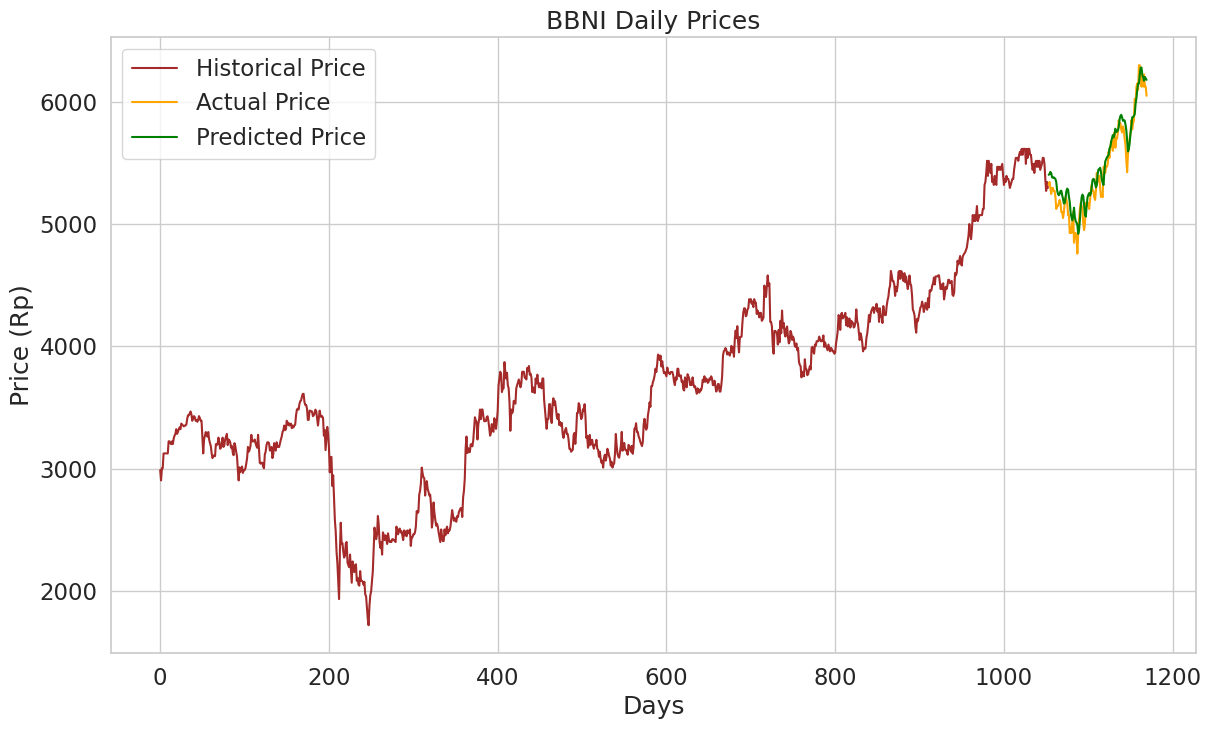

In [24]:
# plot for whole range of data
plt.plot(np.arange(0, len(y_train)), scaler.inverse_transform(y_train), color='brown', label='Historical Price')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test_orig)), y_test_orig, color='orange', label='Actual Price')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_pred_orig)), y_pred_orig, color='green', label='Predicted Price')

plt.title('BBNI Daily Prices')
plt.xlabel('Days')
plt.ylabel('Price (Rp)')
plt.legend()
plt.show();
